In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# allow to display plots
%matplotlib inline

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from math import sqrt
from random import randint

import xgboost as xgb

In [210]:
df = pd.read_csv('parse_result.csv')
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2391 entries, 0 to 2390
Data columns (total 8 columns):
id              2391 non-null int64
price           2391 non-null int64
district        2391 non-null object
square          2391 non-null float64
rooms           2391 non-null int64
date            2391 non-null datetime64[ns]
price/square    2391 non-null float64
price/rooms     2391 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 149.5+ KB


In [211]:
districts = ['district_Голосіївський',
       'district_Дарницький', 'district_Деснянський', 'district_Дніпровський',
       'district_Оболонський', 'district_Печерський', 'district_Подільський',
       'district_Святошинський', "district_Солом'янський",
       'district_Шевченківський']

df_mean_price = np.mean(df['price'])

districts_dict = {
            'district_Голосіївський':0,
            'district_Дарницький':0, 
            'district_Деснянський':0, 
            'district_Дніпровський':0,
            'district_Оболонський':0, 
            'district_Печерський':0, 
            'district_Подільський':0,
            'district_Святошинський':0, 
            "district_Солом'янський":0,
            'district_Шевченківський':0
}

In [212]:
mean_square_disctricts = df.groupby('district')['square'].apply(lambda x: np.mean(x)).to_dict()
median_square_disctricts = df.groupby('district')['square'].apply(lambda x: np.median(x)).to_dict()

mean_rooms_disctricts = df.groupby('district')['rooms'].apply(lambda x: np.mean(x)).to_dict()
median_rooms_disctricts = df.groupby('district')['rooms'].apply(lambda x: np.median(x)).to_dict()

avg_price_per_room_disctricts = df.groupby('district')['price/rooms'].apply(lambda x: np.mean(x)).to_dict()
avg_price_per_square_disctricts = df.groupby('district')['price/square'].apply(lambda x: np.mean(x)).to_dict()

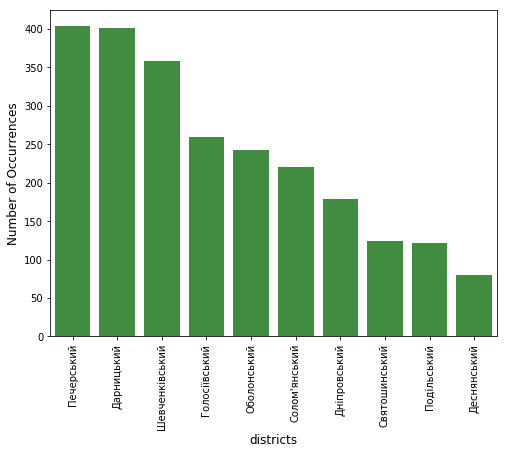

In [213]:
counted_values = df['district'].value_counts()

plt.figure(figsize=(8,6))
sns.barplot(counted_values.index, counted_values.values, 
            alpha=0.8, 
            color='green') # w/o set color will be rainbow
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('districts', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

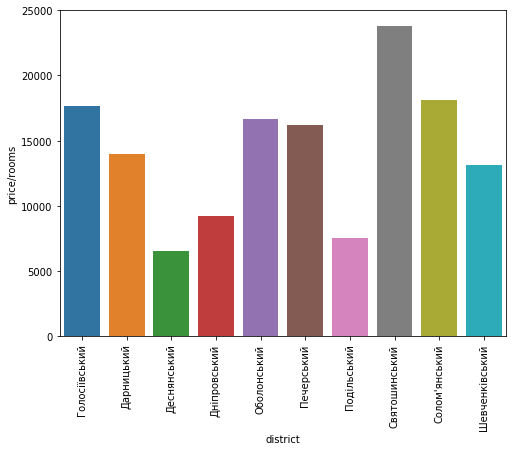

In [214]:
price_mean = df[["district", "price/rooms"]].groupby(['district'], as_index=False).mean()

plt.figure(figsize=(8,6))
sns.barplot(x='district', y='price/rooms', data=price_mean)
plt.xticks(rotation='vertical')
plt.show()

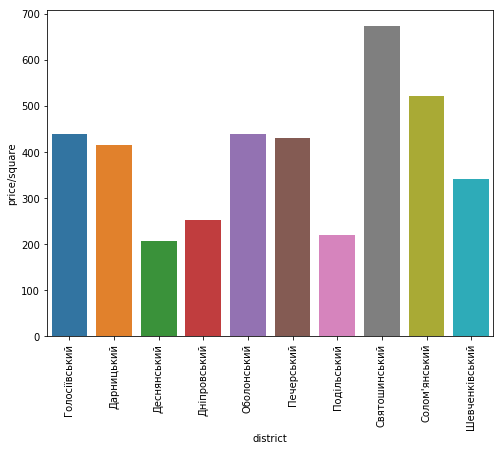

In [215]:
price_mean = df[["district", "price/square"]].groupby(['district'], as_index=False).mean()

plt.figure(figsize=(8,6))
sns.barplot(x='district', y='price/square', data=price_mean)
plt.xticks(rotation='vertical')
plt.show()

In [216]:
df = df.drop(labels=['price/square', 'price/rooms', 'date', 'id'], axis=1)

In [217]:
df.head()

price       district  square  rooms
0   9500  Голосіївський    40.0      1
1  10000     Дарницький    68.0      3
2  10900     Дарницький    50.0      1
3  29000     Печерський   110.0      3
4  16000  Солом'янський    70.0      3

## preprocessing and some plots

In [218]:
def df_preprocessing(df, onehot=False):
    df['dev_mean_square_district'] = df.apply(lambda x: x['square'] - mean_square_disctricts.get(x['district']), 
                                              axis=1)
    df['dev_median_square_district'] = df.apply(lambda x: x['square'] - median_square_disctricts.get(x['district']),
                                                axis=1)
  
    df['dev_mean_rooms_district'] = df.apply(lambda x: x['rooms'] - mean_rooms_disctricts.get(x['district']), 
                                             axis=1)
    df['dev_median_rooms_district'] = df.apply(lambda x: x['rooms'] - median_rooms_disctricts.get(x['district']), 
                                               axis=1)
  
    df['avg_price_per_room_disctricts'] = df.apply(lambda x: avg_price_per_room_disctricts.get(x['district']), 
                                                   axis=1)
    
    df['avg_price_per_square_disctricts'] = df.apply(lambda x: avg_price_per_square_disctricts.get(x['district']), 
                                               axis=1)
  
    df['avg_room_size'] = df.apply(lambda x: x['square'] / x['rooms'], axis=1)
    
    if onehot:
        df = pd.get_dummies(df, columns=['district'])
    return df

In [219]:
def data_format_for_predicting(data:dict):
    data.update(districts_dict)
    district = [s for s in districts if data['district'] in s][0]
    data[district] = 1
    
    df = pd.DataFrame([data])
    df = df_preprocessing(df)
    df = df.drop(labels=['district'], axis=1)
    
    return df

In [220]:
df = df_preprocessing(df, onehot=True)

In [221]:
df.head()

price  square  rooms  dev_mean_square_district  dev_median_square_district  \
0   9500    40.0      1                -31.907692                       -22.0   
1  10000    68.0      3                  4.850873                        12.0   
2  10900    50.0      1                -13.149127                        -6.0   
3  29000   110.0      3                 18.635891                        32.0   
4  16000    70.0      3                 -2.361538                         8.0   

   dev_mean_rooms_district  dev_median_rooms_district  \
0                -1.050000                       -1.0   
1                 1.221945                        1.0   
2                -0.778055                       -1.0   
3                 0.579208                        1.0   
4                 0.877828                        1.0   

   avg_price_per_room_disctricts  avg_price_per_square_disctricts  \
0                   17653.962244                       439.381509   
1                   13991.219036                       415.647520   
2                   13991.219036                       415.647520   
3                   16187.409530                       430.502061   
4                   18138.784691                       522.127107   

   avg_room_size  district_Голосіївський  district_Дарницький  \
0      40.000000                       1                    0   
1      22.666667                       0                    1   
2      50.000000                       0                    1   
3      36.666667                       0                    0   
4      23.333333                       0                    0   

   district_Деснянський  district_Дніпровський  district_Оболонський  \
0                     0                      0                     0   
1                     0                      0                     0   
2                     0                      0                     0   
3                     0                      0                     0   
4                     0                      0                     0   

   district_Печерський  district_Подільський  district_Святошинський  \
0                    0                     0                       0   
1                    0                     0                       0   
2                    0                     0                       0   
3                    1                     0                       0   
4                    0                     0                       0   

   district_Солом'янський  district_Шевченківський  
0                       0                        0  
1                       0                        0  
2                       0                        0  
3                       0                        0  
4                       1                        0

## Training

In [367]:
X, y = df.drop(labels=['price'], axis=1), df[['price']]

columns_order = X.columns

### Xgboost

In [368]:
kf = KFold(n_splits=5, shuffle=True, random_state=256)

In [369]:
xgb_params = {
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [370]:
print('train xgboost on 5 folds')

r2 = []
rmse = []
mae = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test)
    
    model = xgb.train(xgb_params, dtrain, num_boost_round=350)
    
    y_predict = model.predict(dtest)
    
    r2.append(r2_score(y_test, y_predict))
    rmse.append(sqrt(mean_squared_error(y_test, y_predict)))
    mae.append(mean_absolute_error(y_test, y_predict))
    
    print('*'*30)
    print('r2_score == {:.2f}'.format(r2[-1]))
    print('rmse == {:.2f}'.format(rmse[-1]))
    print('mae == {:.2f}'.format(mae[-1]))
    
print()
print('***** Avarage scores: *****')

print('r2_score == {:.2f}'.format(np.mean(r2)))
print('rmse == {:.2f}'.format(np.mean(rmse)))
print('mae == {:.2f}'.format(np.mean(mae)))

train xgboost on 5 folds
******************************
r2_score == -0.36
rmse == 130456.81
mae == 22756.79
******************************
r2_score == -0.03
rmse == 246071.88
mae == 30795.26
******************************
r2_score == -2.63
rmse == 48835.52
mae == 14760.51
******************************
r2_score == 0.01
rmse == 202282.03
mae == 25532.81
******************************
r2_score == -0.95
rmse == 138257.18
mae == 25472.16

***** Avarage scores: *****
r2_score == -0.79
rmse == 153180.68
mae == 23863.50


In [729]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=256)

In [730]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=350)

In [731]:
y_predict = xgb_model.predict(dtest)
print('*'*30)
print('r2_score == {:.2f}'.format(r2_score(y_test, y_predict)))
print('rmse == {:.2f}'.format(sqrt(mean_squared_error(y_test, y_predict))))
print('mae == {:.2f}'.format(mean_absolute_error(y_test, y_predict)))

******************************
r2_score == -0.09
rmse == 204265.11
mae == 27418.02


### LASSO and Ridge regression

In [239]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [322]:
y_pred = ridge.predict(X_test)
print('*'*30)
print('r2_score == {:.2f}'.format(r2_score(y_test, y_predict)))
print('rmse == {:.2f}'.format(sqrt(mean_squared_error(y_test, y_predict))))
print('mae == {:.2f}'.format(mean_absolute_error(y_test, y_predict)))

******************************
r2_score == -0.09
rmse == 204265.11
mae == 27418.02


In [323]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

/Users/user/PycharmProjects/FlatPrice/venv3.5/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [324]:
y_pred = lasso.predict(X_test)
print('*'*30)
print('r2_score == {:.2f}'.format(r2_score(y_test, y_predict)))
print('rmse == {:.2f}'.format(sqrt(mean_squared_error(y_test, y_predict))))
print('mae == {:.2f}'.format(mean_absolute_error(y_test, y_predict)))

******************************
r2_score == -0.09
rmse == 204265.11
mae == 27418.02


## Demo

In [610]:
pickle.dump(xgb_model, open("xgboost.pickle.dat", "wb"))
del xgb_model

In [628]:
xgb_model = pickle.load(open("xgboost.pickle.dat", "rb"))

In [732]:
rand_inx = randint(0, len(X))

test_sample = xgb.DMatrix(X[rand_inx:rand_inx+1])
pred_value = xgb_model.predict(test_sample)[0]
real_value = y[rand_inx:rand_inx+1].values[0][0]

In [733]:
print('Predicted value == {:.2f}'.format(pred_value))
print('Real value == {:.2f}'.format(real_value))
print('Relative percentage error == {:.2f} %'.format(np.abs((pred_value - real_value) / real_value) * 100))

Predicted value == 71671.32
Real value == 61600.00
Relative percentage error == 16.35 %


In [750]:
data = {
        'district': "Дарницький",
        'square': 100,
        "rooms": 3
}

x = data_format_for_predicting(data)[columns_order]

In [1]:
x

NameError: name 'x' is not defined

In [752]:
test_sample = xgb.DMatrix(x)
pred_value = xgb_model.predict(test_sample)[0]
real_value = y[rand_inx:rand_inx+1].values[0][0]

In [753]:
print('Predicted value == {:.2f}'.format(pred_value))
print('Real value == {:.2f}'.format(real_value))
print('Relative percentage error == {:.2f} %'.format(np.abs((pred_value - real_value) / real_value) * 100))

Predicted value == 16045.37
Real value == 61600.00
Relative percentage error == 73.95 %
